ChEn-3170: Computational Methods in Chemical Engineering Fall 2020 UMass Lowell; Prof. V. F. de Almeida **10Nov20**

# 14. Single Reaction at Equilibrium
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{x}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\abs}[1]{\left\lvert{#1}\right\rvert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \DeclareMathOperator{\gradx}{\nabla\!_{\xvec}}
  \newcommand{\Kcal}{\mathcal{K}}
$

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Algorithm](#algo)
* [Input Data 1](#data1)
 - [Plot Equilibrium Function](#pef1)
 - [Solve for Equilibrium](#solve1)
 - [Plot Equilibrium Point](#pep1)
* [Input Data 2](#data2)
 - [Plot Equilibrium Function](#pef2)
 - [Solve for Equilibrium](#solve2)
 - [Plot Equilibrium Point](#pep2)
* [Input Data 3](#data3)
 - [Plot Equilibrium Function](#pef3)
 - [Solve for Equilibrium](#solve3)
 - [Plot Equilibrium Point](#pep3)
---

## [Introduction](#toc)<a id="intro"></a>
In the previous [notebook](https://nbviewer.jupyter.org/github/dpploy/chen-3170/blob/master/notebooks/13-nonlinear-root-finding.ipynb), an algorithm was developed for finding the equilibrium molar fractions of a single reversible chemical reaction with a fixed stoichiometry and fixed number of chemical species. Here we expand
Newton's method for computing roots of a single non-linear equation, $\Kcal\bigl(\xvec(\widehat{\varepsilon})\bigr)=0$, for variable stoichiometry and variable number of chemical species, described in the course notes OneNote [ChEn-3170-nonlinalg-b](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Et5dh9qx7wlIhSwTMHlUejoBEmLfisX9lBT-wHs5zVttgQ?e=WhR37k).

The task at hand is to compute the equilibrium molar fraction of species undergoing a reversible reaction for an arbitrary number of species and an arbitrary stoichiometry, say

\begin{equation*}
\nu_A\,\text{A} + \nu_B\,\text{B} \overset{K_x}{\longleftrightarrow} \nu_C\,\text{C} + \nu_D\,\text{D}    ,
\end{equation*}

that is, compute $x_A$, $x_B$, $x_C$, $x_D$ for the given stoichiometry and molar equilibrium reaction constant $K_x$. Note that this information is not sufficient for computing the equilibrium molar fraction. In addition, it is required that the molar fraction of **any three species is known** at some point in time or as a reference, say $x_{A_0}$, $x_{B_0}$, and $x_{C_0}$; note $x_{A_0} + x_{B_0} + x_{C_0} + x_{D_0}= 1$.

In this case we write the equilibrium function as

\begin{equation*}
\Kcal\bigl(\xvec\bigr)= K_x - \prod\limits_{j=\text{A,B,C,D}}\, x_j^{S_{1,j}} = 0,
\end{equation*}

where the molar fraction vector is defined as $\xvec = (x_A, x_B, x_C, x_c)$, the first row of elements of the stoichiometric matrix is denoted as ${S_{1,j}}$. This form of the equilibrium equation holds for any reversible chemical reaction by extending the product of powers of the molar fractions. Therefore a general solution method will result from adopting this particular form of a reaction equilibrium function.

In [1]:
'''Equilibrium function'''

def keq_function( x_vec, eq_kx_cte, stoic_row ):
    
    value = eq_kx_cte - x_vec[0]**stoic_row[0] * x_vec[1]**stoic_row[1] \
                        * x_vec[2]**stoic_row[2] * x_vec[3]**stoic_row[3]
    
    return value

The molar fractions vector are a function of the normalized extent of reaction

\begin{equation*}
\xvec(\widehat{\varepsilon}) = \frac{\xvec^{(0)} + \widehat{\varepsilon}\,\Smtrx_{1,\bullet}}{1+\widehat{\varepsilon}\sum\limits_j S_{1,j}} ,
\end{equation*}

where $\xvec^{(0)} = (x_{A_0}, x_{B_0}, x_{C_0}, x_{D_0})$.

In [2]:
'''Molar fractions function'''

def molar_fractions(ext_hat, x_vec_0, stoic_row):
    
    assert abs(x_vec_0.sum()-1.0) <= 1e-10
    assert abs( 1.0 + ext_hat * stoic_row.sum() ) >= 1e-8
    
    x_vec = ( x_vec_0 + ext_hat * stoic_row ) / \
            ( 1.0 + ext_hat * stoic_row.sum() )
    
    return x_vec

The usage of Newton's method to compute an equilibrium molar fraction solution requires the value of 
$\Kcal\bigl(\xvec(\widehat{\varepsilon})\bigr)$ at different values of $\widehat{\varepsilon}$ and the total derivative

\begin{equation*}
d_{\widehat{\varepsilon}} \Kcal\bigl(\xvec(\widehat{\varepsilon})\bigr) = 
                       \gradx\Kcal \cdot d_{\widehat{\varepsilon}}\xvec
\end{equation*}

where the molar fraction gradient is 

\begin{equation*}
 \gradx\Kcal = - 
  K_x \begin{pmatrix} 
       S_{1,A}\,x_A^{-1} \\ 
       S_{1,B}\,x_B^{-1} \\
       S_{1,C}\,x_C^{-1} \\
       S_{1,D}\,x_D^{-1} 
       \end{pmatrix} .
\end{equation*}

In [3]:
'''Gradient wrt molar fractions of the equilibrium function'''

def grad_x_k_function( x_vec, eq_kx_cte, stoic_row ):
    
    import numpy as np
    x_vec_local = np.copy(x_vec)
    
    # correct for division by a very small number (initial null charge; final fully consumed species)
    max_x = x_vec_local.max()
    for i in range(x_vec_local.size):
        if x_vec_local[i] < 1e-8:
            x_vec_local[i] = max_x # some reasonable mole fraction
            
    x_vec_inv = 1.0/x_vec_local
    
    grad_vec = -eq_kx_cte * stoic_row*x_vec_inv
    
    return grad_vec

The molar fraction derivative is

\begin{equation*}
  d_{\widehat{\varepsilon}}\xvec = \frac{\Smtrx_{1,j} - \xvec^{(0)}\,\sum_j S_{1,j}}
                                { \bigl(1 + \widehat{\varepsilon}\,\sum_j S_{1,j}\bigr)^2 } .
\end{equation*}


In [4]:
'''Derivative of the molar fractions function wrt normalized extent of reaction'''

def d_ext_molar_fractions(ext_hat, x_vec_0, stoic_row):
    
    dext_x_vec = ( stoic_row - x_vec_0 * stoic_row.sum() ) / \
                 ( 1.0 + ext_hat * stoic_row.sum() )**2
    
    return dext_x_vec

## [Algorithm](#toc)<a id="algo"></a>

Given $\Kcal\bigl(\xvec(\widehat{\varepsilon})\bigr)$, find the root

\begin{equation*}
\Kcal\bigl(\xvec(\widehat{\varepsilon})\bigr) = 0 ,
\end{equation*}

using an iterative method based on the initial guess $\widehat{\varepsilon}_0$. Compute the updates

\begin{equation*}
\delta \widehat{\varepsilon}_k = - \frac{ \Kcal\bigl(\xvec(\widehat{\varepsilon}_{k-1})\bigr)}
                                     {d_{\widehat{\varepsilon}}\Kcal\bigl(\xvec(\widehat{\varepsilon}_{k-1})\bigr)} 
                                     \ \qquad \  \forall \ \qquad \ k = 1,\ldots,k_\text{max} , 
\end{equation*}

then compute the approximation to the root

\begin{equation*}
 \widehat{\varepsilon}_k = \widehat{\varepsilon}_{k-1} + \delta \widehat{\varepsilon}_k \ \qquad \  \forall \ \qquad\ \ k = 1,\ldots,k_\text{max} ,
\end{equation*}

until convergence, say, $\abs{\delta\widehat{\varepsilon}_k} \le 10^{-8}$ and $\abs{\Kcal\bigl(\xvec(\widehat{\varepsilon}_k)\bigr)} \le 10^{-8}$, or no convergence achieved , say $k>k_\text{max}$. 

In [5]:
'''Newton's method'''

def newton_solve( x_vec_0, eq_kx_cte, stoic_row,
                  ext_hat_0=0.0, k_max=30, tolerance=1.0e-10, verbose=True ):

    # Other initialization
    delta_k = 1e+10
    keq_k   = 1e+10     # equilibrium function initial value
    ext_hat = ext_hat_0

    if verbose is True:
        print('\n')
        print('******************************************************')
        print("          Newton's Method Iterations                  ")
        print('******************************************************')
        print("k |  K(e_k)  |  K'(e_k) | |del e_k| |    e_k   |convg|")
        print('------------------------------------------------------')

    import math
    k = 0
    
    while (abs(delta_k) > tolerance or abs(keq_k) > tolerance) and k <= k_max:
        
        # compute the molar fractions
        x_vec = molar_fractions( ext_hat, x_vec_0, stoic_row ) 
        
        # compute the equilibrium function
        keq_k   = keq_function( x_vec, eq_kx_cte, stoic_row )
        
        # compute the molar fraction gradient of the equilibrium function
        grad_x_k = grad_x_k_function( x_vec, eq_kx_cte, stoic_row )
        
        # compute the extent of reaction derivative of the molar fraction
        d_ext_x = d_ext_molar_fractions( ext_hat, x_vec_0, stoic_row )
        
        # form the total derivative of the equilibrium function wrt the extent of reaction
        d_ext_keq_k = np.dot( grad_x_k , d_ext_x )
        
        # compute the Newton update    
        delta_k_old = delta_k # save previous Newton update for convergence monitoring
        
        delta_k = - keq_k / d_ext_keq_k
        
        # make sure iterates are moving towards root
        keq_k_old = keq_k
        step_size = 1.0
        x_vec = molar_fractions(ext_hat + delta_k, x_vec_0, stoic_row)
        keq_k = keq_function(x_vec, eq_kx_cte, stoic_row)
        
        while (abs(keq_k) > abs(keq_k_old)):
            step_size *= 0.5
            x_vec = molar_fractions(ext_hat + step_size * delta_k, x_vec_0, stoic_row)
            keq_k = keq_function(x_vec, eq_kx_cte, stoic_row)
        
        # compute the update to the root candidate
        ext_hat += step_size* delta_k
        
        if k > 0:
            if delta_k != 0.0 and delta_k_old != 0.0:
                convergence_factor = math.log(abs(delta_k),10) / math.log(abs(delta_k_old),10)
            else:
                convergence_factor = 0.0  
        else:
            convergence_factor = 0.0
            
        k = k + 1
        
        if verbose is True:
            print('%2i %+5.3e %+5.3e %+5.3e  %+5.3e %5.2f'%\
                  (k,keq_k,d_ext_keq_k,abs(delta_k),ext_hat,convergence_factor))

    if verbose is True:
        print('******************************************************') 
        print('Root = %8.5e'%ext_hat)
    
    return ext_hat

## [Input Data 1](#toc)<a id="data1"></a>

Reversible reaction: 
$\nu_A\,\text{A} + \nu_B\,\text{B} \overset{K_x}{\longleftrightarrow} \nu_C\,\text{C} + \nu_D\,\text{D}$ 

Name                        | Parameter    | Value | Name     | Parameter | Value |
----------------------------|--------------|-------|----------|-----------|-------|
initial molar fraction of A  | $x_{A_0}$    | 0.5   | stoic. A | $\nu_A$   |  0.7  |
initial molar fraction of B  | $x_{B_0}$    | 0.5   | stoic. B | $\nu_B$   |  1.3  |
initial molar fraction of C  | $x_{C_0}$    | 0.0   | stoic. C | $\nu_C$   |  1.7  |
initial molar fraction of C  | $x_{D_0}$    | 0.0   | stoic. D | $\nu_D$   |  0.5  |
molar equilibrium constant   | $K_\text{x}$ | 108   |    .     |    .      |   .   |

In [6]:
'''Parameters for chemical equilibrium of A + B <-> C + D'''

x_a_0 = 0.5
x_b_0 = 0.5
x_c_0 = 0.
x_d_0 = 0.

species_names = ['A','B','C','D']

import numpy as np
stoic_row = np.array([-0.7, -1.3, 1.7, 0.5])

reaction =  str(-stoic_row[0])+' A + '+str(-stoic_row[1])+' B '\
           +' <=> '\
           +str(stoic_row[2])+' C + '+str(stoic_row[3])+' D '

x_vec_0 = np.array([x_a_0, x_b_0, x_c_0, x_d_0])

assert abs(np.sum(x_vec_0) - 1.0) <= 1e-12
assert np.all(x_vec_0 >=0.0)

eq_kx_cte = 108.0

print('reaction: ',reaction)

reaction:  0.7 A + 1.3 B  <=> 1.7 C + 0.5 D 


In [7]:
'''Bounds on extent of reaction'''

(ids,) = np.where(stoic_row>0)
ext_hat_min = np.max(-x_vec_0[ids]/np.abs(stoic_row[ids]))

(ids,) = np.where(stoic_row<0)
ext_hat_max = np.min( x_vec_0[ids]/np.abs(stoic_row[ids]))

# reduce the ends of the interval by 1% to avoid infinite values in the equilibrium function
dext = (ext_hat_max - ext_hat_min)*.01
ext_hat_min += dext
ext_hat_max -= dext

print('ext_hat_min = %+1.3e'%ext_hat_min)
print('ext_hat_max = %+1.3e'%ext_hat_max)

ext_hat_min = +3.846e-03
ext_hat_max = +3.808e-01


In [8]:
'''Function: plot K equilibrium function'''

def plot_keq_function( ex_min, ex_max, n_pts,
                   x_vec_0, eq_kx_cte, stoic_row,
                   ext_hat_root=None  ):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    plt.figure(1, figsize=(8, 6))
    
    import numpy as np
    ex_vec = np.linspace(ex_min, ex_max, n_pts)
    
    keq_function_values = list() # space to save equilibrium function values
    for e in ex_vec:
        x_vec = molar_fractions( e, x_vec_0, stoic_row ) 
        keq_function_values.append( keq_function( x_vec, eq_kx_cte, stoic_row ) )
    
    plt.plot(ex_vec, keq_function_values,'b-',label='$K_{eq}$')
    
    plt.xlabel(r'$\hat{\varepsilon}$',fontsize=18)
    plt.ylabel(r'$K(\hat{\varepsilon})$',fontsize=18)
    plt.title(reaction,fontsize=20)
    #plt.legend(loc='best',fontsize=12)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    (x_min,x_max) = plt.xlim()
    dx = abs(x_max-x_min)
    x_text = x_max + dx * .10
    
    (y_min,y_max) = plt.ylim()
    dy = abs(y_max-y_min)
    y_text = y_max - dy*0.05
    
    for x,spc in zip(x_vec_0,species_names):
        
        plt.text(x_text, y_text, 'x_%s_0=%8.2e'%(spc,x),fontsize=16)
        y_text -= dy*0.06
    
    y_text -= dy*0.06
    plt.text(x_text, y_text, r'$K_x=$%8.2e'%eq_kx_cte,fontsize=16)
    
    
    if ext_hat_root is not None:
        
        plt.plot(ext_hat_root, 0.0,'r*',label='root',markersize=14)
               
        (x_min,x_max) = plt.xlim()
        dx = abs(x_max-x_min)
        x_text = ext_hat_root + dx*0.01
    
        (y_min,y_max) = plt.ylim()
        dy = abs(y_max-y_min)
        y_text = 0.0 + dy*0.01
    
        plt.text(x_text, y_text, r'$\hat{\varepsilon}^*=$%8.2e'%ext_hat_root,fontsize=16)
    
    
    plt.grid(True)
    plt.show()
    print('')
    
    return

### [Plot Equilibrium Function 1](#toc)<a id="pef1"></a>

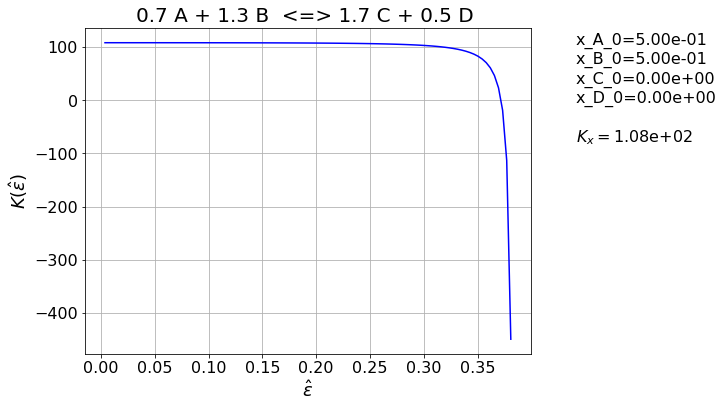

In [9]:
'''Plot equilibrium function'''

n_pts = 100

plot_keq_function( ext_hat_min, ext_hat_max, n_pts, 
                   x_vec_0, eq_kx_cte, stoic_row )

### [Solve for Equilibrium 1](#toc)<a id="solve1"></a>

In [10]:
'''Find root and equilibrium molar fractions'''

ext_hat_0 = (ext_hat_max + ext_hat_min)/2.0
k_max = 20
tolerance = 1.0e-8

ext_hat = newton_solve( x_vec_0, eq_kx_cte, stoic_row,
                        ext_hat_0, k_max, tolerance )

x_vec = molar_fractions( ext_hat, x_vec_0, stoic_row )

print('')
print('Equilibrium mole fractions:\n')
for (x,spc) in zip(x_vec,species_names):
    print('x_%s = %5.3e (%4.1f%%)'%(spc,x,round(x*100,1)))
    
assert np.all(x_vec >= 0.0)
assert abs(x_vec.sum() - 1.0) <= 1e-10



******************************************************
          Newton's Method Iterations                  
******************************************************
k |  K(e_k)  |  K'(e_k) | |del e_k| |    e_k   |convg|
------------------------------------------------------
 1 +1.065e+02 -2.106e+03 +5.101e-02  +2.433e-01  0.00
 2 +1.036e+02 -2.127e+03 +5.007e-02  +2.934e-01  1.01
 3 +9.441e+01 -2.524e+03 +4.105e-02  +3.344e-01  1.07
 4 +6.588e+01 -3.704e+03 +2.549e-02  +3.599e-01  1.15
 5 +1.796e+01 -6.558e+03 +1.005e-02  +3.700e-01  1.25
 6 +6.315e-01 -1.045e+04 +1.719e-03  +3.717e-01  1.38
 7 +6.313e-04 -1.172e+04 +5.386e-05  +3.718e-01  1.54
 8 +6.259e-10 -1.177e+04 +5.363e-08  +3.718e-01  1.70
 9 +5.684e-14 -1.177e+04 +5.318e-14  +3.718e-01  1.83
******************************************************
Root = 3.71752e-01

Equilibrium mole fractions:

x_A = 2.232e-01 (22.3%)
x_B = 1.557e-02 ( 1.6%)
x_C = 5.882e-01 (58.8%)
x_D = 1.730e-01 (17.3%)


### [Plot Equilibrium Point 1](#toc)<a id="pep1"></a>

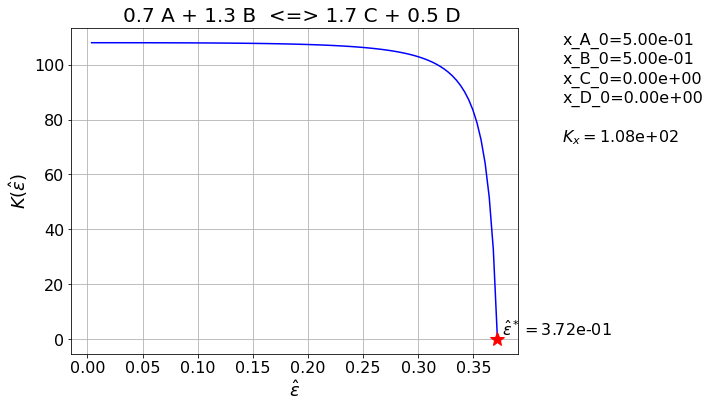

In [11]:
'''Plot equilibrium function with root'''

n_pts = 100

plot_keq_function( ext_hat_min, ext_hat, n_pts, 
                   x_vec_0, eq_kx_cte, stoic_row, ext_hat )

## [Input Data 2](#toc)<a id="data2"></a>

Reversible reaction: 
$\nu_A\,\text{A} + \nu_B\,\text{B} \overset{K_x}{\longleftrightarrow} \nu_C\,\text{C} + \nu_D\,\text{D}$ 

Name                        | Parameter    | Value | Name     | Parameter | Value |
----------------------------|--------------|-------|----------|-----------|-------|
initial mole fraction of A  | $x_{A_0}$    | 0.22  | stoic. A | $\nu_A$   |  0.7  |
initial mole fraction of B  | $x_{B_0}$    | 0.51  | stoic. B | $\nu_B$   |  1.3  |
initial mole fraction of C  | $x_{C_0}$    | 0.17  | stoic. C | $\nu_C$   |  1.7  |
initial mole fraction of C  | $x_{D_0}$    | 0.10  | stoic. D | $\nu_D$   |  0.5  |
mole equilibrium constant   | $K_\text{x}$ | 108   |    .     |     .     |   .   |

In [12]:
'''Parameters for chemical equilibrium of A + B <-> C + D'''

x_a_0 = 0.22
x_b_0 = 0.51
x_c_0 = 0.17
x_d_0 = 0.10

species_names = ['A','B','C','D']

import numpy as np
stoic_row = np.array([-0.7, -1.3, 1.7, 0.5])

reaction =  str(-stoic_row[0])+' A + '+str(-stoic_row[1])+' B '\
           +' <=> '\
           +str(stoic_row[2])+' C + '+str(stoic_row[3])+' D '

x_vec_0 = np.array([x_a_0, x_b_0, x_c_0, x_d_0])

assert abs(np.sum(x_vec_0) - 1.0) <= 1e-12
assert np.all(x_vec_0 >=0.0)

eq_kx_cte = 108.0

print('reaction: ',reaction)

reaction:  0.7 A + 1.3 B  <=> 1.7 C + 0.5 D 


In [13]:
'''Bounds on extent of reaction'''

(ids,) = np.where(stoic_row>0)
ext_hat_min = np.max(-x_vec_0[ids]/np.abs(stoic_row[ids]))

(ids,) = np.where(stoic_row<0)
ext_hat_max = np.min( x_vec_0[ids]/np.abs(stoic_row[ids]))

# reduce the ends of the interval by 1% to avoid infinite values in the equilibrium function
dext = (ext_hat_max - ext_hat_min)*.01
ext_hat_min += dext
ext_hat_max -= dext

print('ext_hat_min = %+1.3e'%ext_hat_min)
print('ext_hat_max = %+1.3e'%ext_hat_max)

ext_hat_min = -9.586e-02
ext_hat_max = +3.101e-01


### [Plot Equilibrium Function 2](#toc)<a id="pef2"></a>

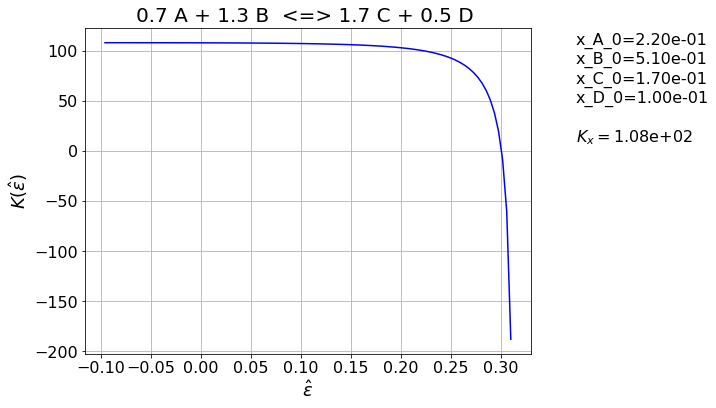

In [14]:
'''Plot equilibrium function'''

n_pts = 100

plot_keq_function( ext_hat_min, ext_hat_max, n_pts, 
                   x_vec_0, eq_kx_cte, stoic_row )

### [Solve for Equilibrium 2](#toc)<a id="solve2"></a>

In [15]:
'''Find root and equilibrium molar fractions'''

ext_hat_0 = (ext_hat_max + ext_hat_min)/2.0
k_max = 20
tolerance = 1.0e-8

ext_hat = newton_solve( x_vec_0, eq_kx_cte, stoic_row,
                        ext_hat_0, k_max, tolerance )

x_vec = molar_fractions( ext_hat, x_vec_0, stoic_row )

print('')
print('Equilibrium mole fractions:\n')
for (x,spc) in zip(x_vec,species_names):
    print('x_%s = %5.3e\n'%(spc,x))

assert np.all(x_vec >= 0.0)
assert abs(x_vec.sum() - 1.0) <= 1e-10



******************************************************
          Newton's Method Iterations                  
******************************************************
k |  K(e_k)  |  K'(e_k) | |del e_k| |    e_k   |convg|
------------------------------------------------------
 1 +1.055e+02 -1.915e+03 +5.590e-02  +1.630e-01  0.00
 2 +1.009e+02 -1.955e+03 +5.397e-02  +2.170e-01  1.01
 3 +8.725e+01 -2.283e+03 +4.420e-02  +2.612e-01  1.07
 4 +5.202e+01 -3.117e+03 +2.799e-02  +2.892e-01  1.15
 5 +8.533e+00 -4.955e+03 +1.050e-02  +2.997e-01  1.27
 6 +8.611e-02 -7.266e+03 +1.174e-03  +3.009e-01  1.48
 7 +7.317e-06 -7.738e+03 +1.113e-05  +3.009e-01  1.69
 8 +7.105e-14 -7.743e+03 +9.450e-10  +3.009e-01  1.82
******************************************************
Root = 3.00895e-01

Equilibrium mole fractions:

x_A = 8.842e-03

x_B = 1.121e-01

x_C = 6.428e-01

x_D = 2.362e-01



### [Plot Equilibrium Point 2](#toc)<a id="pep2"></a>

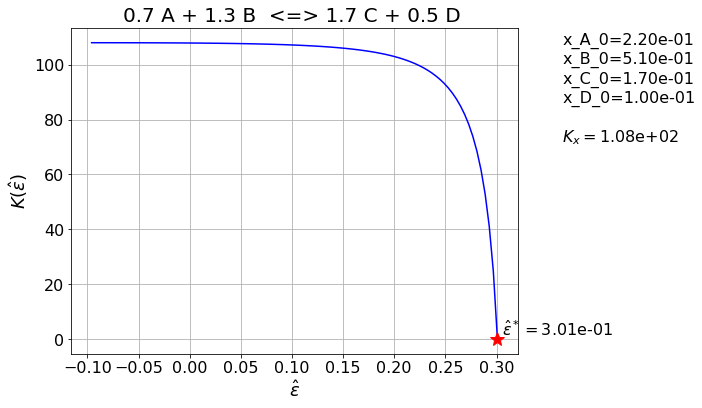

In [16]:
'''Plot equilibrium function with root'''

n_pts = 100

plot_keq_function(ext_hat_min, ext_hat, n_pts, 
                   x_vec_0, eq_kx_cte, stoic_row, ext_hat)

## [Input Data 3](#toc)<a id="data3"></a>

Reversible reaction: 
$\nu_A\,\text{A} + \nu_B\,\text{B} \overset{K_x}{\longleftrightarrow} \nu_C\,\text{C} + \nu_D\,\text{D}$ 

Name                        | Parameter    | Value | Name     | Parameter | Value |
----------------------------|--------------|-------|----------|-----------|-------|
initial mole fraction of A  | $x_{A_0}$    | 0.07  | stoic. A | $\nu_A$   |  1.7  |
initial mole fraction of B  | $x_{B_0}$    | 0.11  | stoic. B | $\nu_B$   |  2.3  |
initial mole fraction of C  | $x_{C_0}$    | 0.32  | stoic. C | $\nu_C$   |  0.2  |
initial mole fraction of C  | $x_{D_0}$    | 0.50  | stoic. D | $\nu_D$   |  1.5  |
mole equilibrium constant   | $K_\text{x}$ | 120   |    .     |  .        |  .    |

In [17]:
'''Parameters for chemical equilibrium of A + B <-> C + D'''

x_a_0 = 0.07
x_b_0 = 0.11
x_c_0 = 0.32
x_d_0 = 0.50

species_names = ['A','B','C','D']

import numpy as np
stoic_row = np.array([-1.7, -2.3, 0.2, 1.5])

reaction =  str(-stoic_row[0])+' A + '+str(-stoic_row[1])+' B '\
           +' <=> '\
           +str(stoic_row[2])+' C + '+str(stoic_row[3])+' D '

x_vec_0 = np.array([x_a_0, x_b_0, x_c_0, x_d_0])

assert abs(np.sum(x_vec_0) - 1.0) <= 1e-12
assert np.all(x_vec_0 >=0.0)

eq_kx_cte = 120.0

print('reaction: ',reaction)

reaction:  1.7 A + 2.3 B  <=> 0.2 C + 1.5 D 


In [18]:
'''Bounds on extent of reaction'''

(ids,) = np.where(stoic_row>0)
ext_hat_min = np.max(-x_vec_0[ids]/np.abs(stoic_row[ids]))

(ids,) = np.where(stoic_row<0)
ext_hat_max = np.min( x_vec_0[ids]/np.abs(stoic_row[ids]))

# reduce the ends of the interval by 1% to avoid infinite values in the equilibrium function
dext = (ext_hat_max - ext_hat_min)*.01
ext_hat_min += dext
ext_hat_max -= dext

print('ext_hat_min = %+1.3e'%ext_hat_min)
print('ext_hat_max = %+1.3e'%ext_hat_max)

ext_hat_min = -3.296e-01
ext_hat_max = +3.743e-02


### [Plot Equilibrium Function 3](#toc)<a id="pef3"></a>

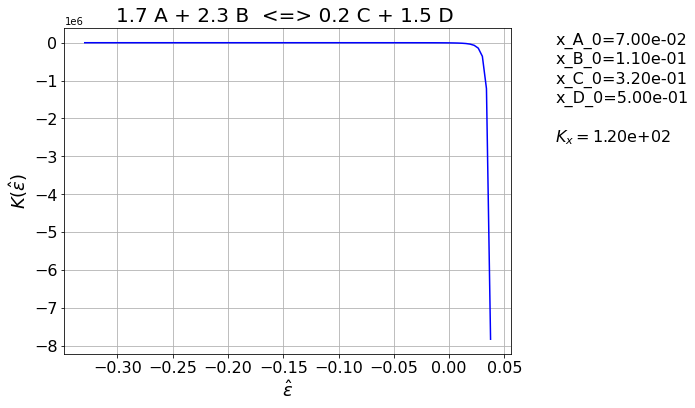

In [19]:
'''Plot equilibrium function'''

n_pts = 100

plot_keq_function(ext_hat_min, ext_hat_max, n_pts, 
                   x_vec_0, eq_kx_cte, stoic_row)

### [Solve for Equilibrium 3](#toc)<a id="solve3"></a>

In [20]:
'''Find root and equilibrium molar fractions'''

ext_hat_0 = (ext_hat_max + ext_hat_min)/2.0
k_max = 20
tolerance = 1.0e-8

ext_hat = newton_solve( x_vec_0, eq_kx_cte, stoic_row,
                        ext_hat_0, k_max, tolerance )

x_vec = molar_fractions( ext_hat, x_vec_0, stoic_row )

print('')
print('Equilibrium mole fractions:\n')
for (x,spc) in zip(x_vec,species_names):
    print('x_%s = %5.3e\n'%(spc,x))
    
assert np.all(x_vec >= 0.0)
assert abs(x_vec.sum() - 1.0) <= 1e-10



******************************************************
          Newton's Method Iterations                  
******************************************************
k |  K(e_k)  |  K'(e_k) | |del e_k| |    e_k   |convg|
------------------------------------------------------
 1 +9.325e+01 -3.015e+03 +3.643e-02  -1.096e-01  0.00
 2 +5.837e+01 -3.419e+03 +2.727e-02  -8.238e-02  1.09
 3 +1.717e+01 -3.970e+03 +1.470e-02  -6.767e-02  1.17
 4 +1.088e+00 -4.408e+03 +3.896e-03  -6.378e-02  1.31
 5 +3.900e-03 -4.547e+03 +2.393e-04  -6.354e-02  1.50
 6 +4.971e-08 -4.555e+03 +8.560e-07  -6.354e-02  1.68
 7 -7.105e-14 -4.555e+03 +1.091e-11  -6.354e-02  1.81
******************************************************
Root = -6.35380e-02

Equilibrium mole fractions:

x_A = 1.553e-01

x_B = 2.235e-01

x_C = 2.681e-01

x_D = 3.531e-01



**Note negative extent of reaction at equilibrium. Compare the equilibrium molar fractions to the initial equilibrium molar fractions.**

### [Plot Equilibrium Point 3](#toc)<a id="pep3"></a>

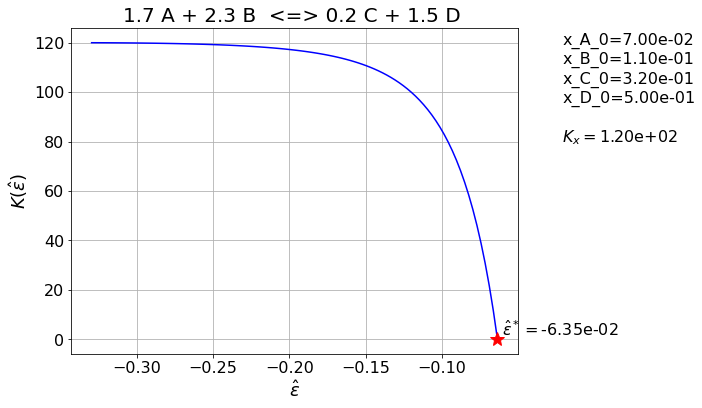

In [21]:
'''Plot equilibrium function with root'''

n_pts = 100

plot_keq_function( ext_hat_min, ext_hat, n_pts, 
                   x_vec_0, eq_kx_cte, stoic_row, ext_hat )